<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="300" alt="cognitiveclass.ai logo"  />
</center>


# Variational Autoencoders


Estimated time needed: **25** minutes


Variational Autoencoders are a type of deep learning generative model. Once you train them on sufficiently large datasets and let them learn latent representations of the data, they can be used to draw faces, plot digits, produce music, and generate anything you can think of.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/vae_intro.jpg" width=60%>


In this lab, we will study the architecture of VAEs. We will build a VAE ourselves using Keras and train the model on the MNIST digits dataset, so that they can be used to generate new images of digits.


## **Table of Contents**

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="https://#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="https://#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="https://#Defining-Helper-Functions">Defining HelperFunctions<a></li>
        </ol>
    </li>
    <li>
        <a href="https://#Dataset">Prepare Dataset</a>
    </li>  
    <li>
        <a href="https://#Variational-Autoencoder">Variational Autoencoder</a>
    </li>
        <li>
        <a href="https://#Encoder Part">Encoder Part</a>
    </li>
     <li>
        <a href="https://#Decoder Part">Decoder Part</a>
    </li>
         <li>
        <a href="https://#Loss-function">Loss function </a>
    </li>
      <li>
        <a href="https://#Putting-it all together">Putting it all together  </a>
    </li>
    <li><a href="https://#Training the VAE">Training the VAE</a></li>

</ol>


## Objectives

After completing this lab you will be able to:

*   Understand the architecture of a Variational Autoencoder
*   Build and train Variational Autoencoder in Keras


***


## Setup


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run these notebook commands in a different Jupyter environment (like Watson Studio or Ananconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [ ]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
# !mamba install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1
# Note: If your environment doesn't support "!mamba install", use "!pip install"

Run the following upgrade and then **RESTART YOUR KERNEL**. Make sure the version of tensorflow imported below is **no less than 2.9.0**.


In [1]:
#%%capture
#!pip3 install --upgrade tensorflow

### Importing Required Libraries

*We recommend you import all required libraries in one place (here):*


In [2]:
# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
import numpy as np

# Import the keras library
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Layer,Reshape,Conv2DTranspose
from tensorflow.python.client import device_lib
from keras.layers import Multiply, Add
from keras import backend as K

from numpy import random

from matplotlib import pyplot as plt

2.19.0


### Defining Helper Functions


In [3]:
def plot_label_clusters(model, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ =encoder.predict(data)
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Preparing the Dataset


We load the MNIST handwritten digit dataset:


In [4]:
# Import data
(X_train, y_train), (_, _) = keras.datasets.mnist.load_data()

There are 60000 $28 \times 28$ images in the training set:


In [5]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

Let's look at the unique labels of the digits that we want to predict:


In [6]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

We will reshape the training set to $60000 \times 28 \times 28 \times 1$ to work with convolutions. 1 indicates that the input images only have one channel, that is: grayscale images.


In [7]:
print(f"Before reshaping, X_train has a shape of: {X_train.shape}")

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
print(f"After reshaping, X_train has a shape of: {X_train.shape}")

Before reshaping, X_train has a shape of: (60000, 28, 28)
After reshaping, X_train has a shape of: (60000, 28, 28, 1)


We cast the data type of `X_train` to `tf.float32` and normalize its values to range from 0 to 1:


In [8]:
X_train = tf.cast(X_train, tf.float32)
X_train = X_train/255.0

We convert the tensors to a `tf.data.Dataset` object.


In [9]:
dataset=tf.data.Dataset.from_tensor_slices(X_train)
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None)>

We can plot five random samples from the training set:


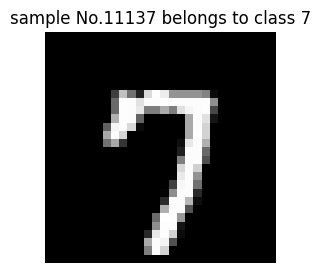

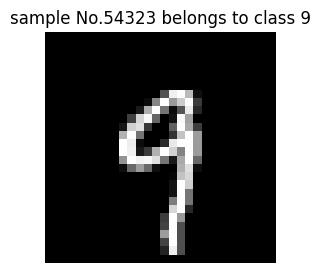

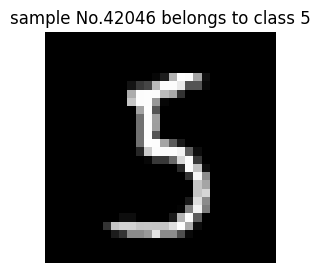

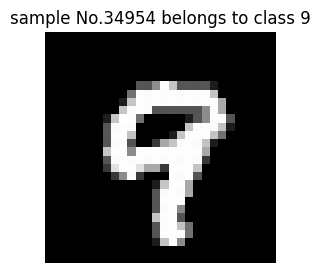

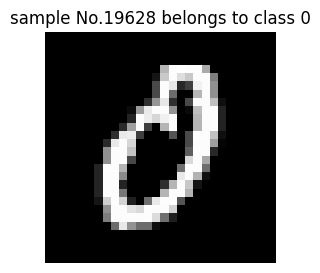

In [10]:
for r in random.randint(0, 59999, size=5, dtype=int):
    
    plt.figure(figsize=(3,3))
    plt.imshow(X_train[r,:,:,0],cmap="gray")
    plt.title("sample No.{} belongs to class {}".format(r,y_train[r]))
    plt.axis("off")

## Variational Autoencoder

In a nutshell, the architecture of a VAE is similar to that of a standard Autoencoder such that it consists of an encoder and a decoder, both of which are trained to minimize the reconstruction error between the original data $X$ and the encoded-decoded data $\hat X$.

The training samples $X$ are passed to the encoder to generate samples $\boldsymbol z$, which are mappings of $X$ in the latent space.  The decoder then uses $\boldsymbol z$ to generate the most likely reconstruction $\hat X$.

At this point, a natural question that comes in mind is, how do we use VAEs to generate meaningful content? You might think that if we train a VAE on images, then we can use it to generate new images. However, since it's difficult to regularize what happens to our encoder output in the latent space, we can't be sure that the encoder will organize information in the latent space in a way that the decoder can easily take that information and generates content that seems reasonable.

Hence, in order to be able to use the VAE for meaningful generative purposes, we need to introduce some regularization into the latent space. As shown in the diagram below, **instead of mapping the input to a single point in the latent space, we encode it as a normal distribution by returning the mean and standard deviation of the distribution**. By doing so, the decoder would be able to use the regularized information to construct new content.

In the following sections, we will build a VAE by following the architecture in the illustrative diagram below.


 <center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/autoencoder.png"" width="800" alt="computer components"  />
<center>


## Encoder Part

We build the encoder part by breaking it up into three smaller parts.

The **first part** of the encoder consists of several fully connected layers, as shown in the picture below, which encodes the high-dimensional input; For our implementation, we will use two **convolution layers** since we want the model to learn the image data using convolutions.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/encoder.png" width="30%" alt="computer components"/></center>


Here is the code for building the first part of the encoder. The `encoder_output` that comes out of the convolution layers is denoted as $\boldsymbol z^2$.


In [11]:
encoder_input= keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
encoder_output = Dense(16, activation="relu")(x)

The **second part** of the encoder represents a normal distribution over the latent space that takes the `encoder_output` and gives you the probability of it belonging to the distribution.

The mean and standard deviation of the normal distribution will be learned and then used to calculate the log-likelihood for optimization purposes.


 <center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/mean_var.png" width="400" alt="computer components"  />
<center>


To implement the second part, we create **two Dense layers** in parallel for the model to learn the **mean** and **log variance** respectively; We want the model to learn the log variance instead of the variance because it brings more stability and ease of training. The detailed reason is as follows:

*   By definition, $\sigma$ is a non-negative real number. To enforce this, we would need to use the ReLU activation to obtain such a value, but the gradient is not well defined around zero.
*   Besides, since we typically apply normalization methods in model training, the data values range from 0 to 1, which means the standard deviation of those values is also very small. This adds a burden to the optimization process and causes numerical instabilities as the gradients flowing in the backpropagation will contain floating points.

Note that we can convert the log variance to the standard deviation using the exponential function. Here is the code for building the second part:


In [15]:
import tensorflow as tf
from keras.layers import Dense, Lambda
from keras import backend as K

latent_dim = 2

# Dense layer to learn the mean
mean = Dense(latent_dim, name="mean")(encoder_output)

# Dense layer to learn the log variance
log_var = Dense(latent_dim, name="z_log_var")(encoder_output)

# Sigma is calculated from log variance using Lambda layer to ensure the operation is valid
sigma = Lambda(lambda x: tf.exp(0.5 * x))(log_var)


In [16]:
#latent_dim = 2

# Dense layer to learn the mean
#mean = Dense(latent_dim, name="mean")(encoder_output)
# Dense layer to learn the log variance
#log_var = Dense(latent_dim, name="z_log_var")(encoder_output)

# sigmia is calculated from log variance
#sigma = tf.exp(0.5 * log_var)

Here comes the **third part** of the encoder, where we sample a point from the learned distribution in the latent space. The sampled point will later be decoded by the decoder to generate new content.

The following diagram illustrates the random sampling:

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/repramateriztion.png" width="400" alt="computer components"  />
<center> 


The sampled point, denoted by $\boldsymbol z^5$ in the diagram, comes from a normal distribution with mean $\mu$ and standard deviation $\sigma$, with some random noise $\epsilon$.


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, Model

latent_dim = 2

# Capa de entrada de ejemplo (simulando un encoder)
input_layer = layers.Input(shape=(10,))  # Suponiendo que la entrada tiene 10 características
encoder_output = layers.Dense(10, activation='relu')(input_layer)  # Salida del codificador

# Capa densa para aprender la media
mean = layers.Dense(latent_dim, name="mean")(encoder_output)

# Capa densa para aprender la varianza logarítmica
log_var = layers.Dense(latent_dim, name="z_log_var")(encoder_output)

# Generar el ruido aleatorio epsilon como parte del grafo de Keras
epsilon = layers.Lambda(lambda x: tf.random.normal(shape=tf.shape(x)))(mean)

# Calcular sigma (desviación estándar) a partir de la varianza logarítmica
sigma = layers.Lambda(lambda x: tf.exp(0.5 * x))(log_var)

# Reconstruir z usando la fórmula z = mean + sigma * epsilon
z = layers.Add()([mean, layers.Multiply()([sigma, epsilon])])

# Crear el modelo
model = Model(inputs=input_layer, outputs=z)

# Mostrar el resumen del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        110 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │         22 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         22 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 2)         │          0 │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 2)         │          0 │ mean[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 2)         │          0 │ lambda_2[0][0],   │
│ (Multiply)          │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2)         │          0 │ mean[0][0],       │
│                     │                   │            │ multiply_2[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 154 (616.00 B)

 Trainable params: 154 (616.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
# random normal noise 
#epsilon = K.random_normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

Due to the random sampling of $\boldsymbol z^5$, we use the [Reparameterization Trick](https://gregorygundersen.com/blog/2018/04/29/reparameterization/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) $ z = \mu + \sigma \odot \epsilon$, which allows the VAE to backpropagate through a random node.


In [26]:
#z = mean + sigma * epsilon 
 
z_eps = Multiply()([sigma, epsilon])
z = Add()([mean, z_eps])

The encoder will output the `mean` and `log_var` of the learned distribution as well as the sampled point `z`. Now, we create the complete encoder network by chaining the `encoder_input` and the `outputs`:


In [27]:
encoder = Model(encoder_input, outputs = [mean, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        110 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │         22 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         22 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 2)         │          0 │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 2)         │          0 │ mean[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 2)         │          0 │ lambda_2[0][0],   │
│ (Multiply)          │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2)         │          0 │ mean[0][0],       │
│                     │                   │            │ multiply_3[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 154 (616.00 B)

 Trainable params: 154 (616.00 B)

 Non-trainable params: 0 (0.00 B)

## Decoder Part

The decoder part of a VAE is the same as that of a regular Autoencoder. To upsample the output from the encoder, we can use the Keras Sequential model API to group a stack of Dense layers and Transpose Convolution layers together.

<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/decoder.png" width="400" alt="computer components"  />
<center>


In [28]:
latent_dim=2
decoder=Sequential()

decoder.add(keras.Input(shape=(latent_dim,))) # input dimension is 2
decoder.add(Dense(7 * 7 * 64, activation="relu"))
decoder.add(Reshape((7, 7, 64)))
decoder.add(Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"))
decoder.add(Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same"))
decoder.add(Conv2DTranspose(1, 3, activation="sigmoid", padding="same"))
decoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

## Loss Function


We include the **reconstruction loss**, which compares the output of the VAE to the original input. In this case, we use the mean square error. We also include a **regularization term**, which regularizes the organization of the latent space by making the distribution learned by the encoder close to a standard normal distribution. The regularization is enforced using the Kullback–Leibler divergence that compares two distributions.


In [29]:
# make loss function 

#reconstruction_loss
def reconstruction_loss(y, y_hat):
    return tf.reduce_mean(tf.square(y - y_hat))


#Kullback–Leibler divergence encoder loss
def kl_loss(mu, log_var):
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
    return loss

# add two losses 
def vae_loss(y_true, y_hat, mu, log_var):
    return reconstruction_loss(y_true, y_hat) + (1 / (64*64)) * kl_loss(mean, log_var)


## Putting it all Together


We combine the Encoder and Decoder to create a VAE, and append the regularization term to the model:


In [36]:
import tensorflow as tf
from tensorflow.keras import layers, Model

latent_dim = 2

# Capa de entrada de ejemplo (simulando un encoder)
input_layer = layers.Input(shape=(10,))  # Suponiendo que la entrada tiene 10 características
encoder_output = layers.Dense(10, activation='relu')(input_layer)  # Salida del codificador

# Capa densa para aprender la media
mean = layers.Dense(latent_dim, name="mean")(encoder_output)

# Capa densa para aprender la varianza logarítmica
log_var = layers.Dense(latent_dim, name="z_log_var")(encoder_output)

# Generar el ruido aleatorio epsilon como parte del grafo de Keras
epsilon = layers.Lambda(lambda x: tf.random.normal(shape=tf.shape(x)))(mean)

# Calcular sigma (desviación estándar) a partir de la varianza logarítmica
sigma = layers.Lambda(lambda x: tf.exp(0.5 * x))(log_var)

# Reconstruir z usando la fórmula z = mean + sigma * epsilon
z = layers.Add()([mean, layers.Multiply()([sigma, epsilon])])

# Crear la capa de decodificación (ejemplo simple)
decoder = layers.Dense(10, activation='relu')  # Suponiendo una decodificación simple
reconstructed = decoder(z)  # Reconstructing input

# Definir la función de pérdida KL
def kl_loss(mean, log_var):
    # Utilizando operaciones compatibles con tensores simbólicos en el grafo
    kl = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
    return kl

# Crear el modelo
model = Model(input_layer, reconstructed, name="vae")

# Calcular la pérdida KL y agregarla como parte de la función de pérdida
kl = kl_loss(mean, log_var)

# Asegurarse de agregar la pérdida KL al modelo correctamente
model.add_loss(kl)

# Mostrar el resumen del modelo
model.summary()


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [40]:
import tensorflow as tf
from tensorflow.keras import layers, Model

latent_dim = 2

# Encoder: Mapea la entrada a la media y la varianza logarítmica
encoder_input = layers.Input(shape=(10,))  # Suponiendo que la entrada tiene 10 características
encoder_output = layers.Dense(10, activation='relu')(encoder_input)

# Capa densa para la media y la varianza logarítmica
mean = layers.Dense(latent_dim, name="mean")(encoder_output)
log_var = layers.Dense(latent_dim, name="z_log_var")(encoder_output)

# Generación de ruido aleatorio y cálculo de z (muestra aleatoria)
epsilon = layers.Lambda(lambda x: tf.random.normal(shape=tf.shape(x)))(mean)
sigma = layers.Lambda(lambda x: tf.exp(0.5 * x))(log_var)
z = layers.Add()([mean, layers.Multiply()([sigma, epsilon])])

# Decoder: Reconstrucción de la entrada a partir de z
decoder = layers.Dense(10, activation='relu')  # Decodificador simple
reconstructed = decoder(z)

# Función para calcular la pérdida KL
def kl_loss(mean, log_var):
    # Calculamos la divergencia KL de la distribución normal
    kl = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
    return kl

# Crear el modelo VAE
model = Model(encoder_input, reconstructed, name="vae")

# Definir una función de pérdida personalizada que se puede agregar al modelo
def vae_loss(y_true, y_pred):
    # Aquí calculamos la pérdida de reconstrucción y la pérdida KL
    reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Agregar la pérdida KL
    kl_loss_value = kl_loss(mean, log_var)
    
    # Pérdida total = reconstrucción + KL
    total_loss = reconstruction_loss + kl_loss_value
    return total_loss

# Compilación del modelo con la pérdida personalizada
model.compile(optimizer='adam', loss=vae_loss)

# Mostrar el resumen del modelo
model.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 10)        │        110 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │         22 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         22 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_17 (Lambda)  │ (None, 2)         │          0 │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 2)         │          0 │ mean[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 2)         │          0 │ lambda_17[0][0],  │
│ (Multiply)          │                   │            │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 2)         │          0 │ mean[0][0],       │
│                     │                   │            │ multiply_10[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 10)        │         30 │ add_13[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 184 (736.00 B)

 Trainable params: 184 (736.00 B)

 Non-trainable params: 0 (0.00 B)

In [42]:
# encoder returns mean and log variance of the normal distribution,
# and a sample point z
#mean, log_var, z = encoder(encoder_input)

# decoder decodes the sample z 
#reconstructed = decoder(z)

#model = Model(encoder_input, reconstructed, name ="vae")
#loss = kl_loss(mean, log_var)
#model.add_loss(loss)
#model.summary()

## Training the VAE

We now train the model. After each epoch, we input random noise <code>z</code> into the decoder. We will see for each epoch, the decoder output will look more and more like a digit.

We also output the values for the latent space z for all the different digits in our dataset, color coded according to class. We see that for each iteration, the samples appeared more clustered.


In [45]:
def plot_label_clusters(encoder, data, labels):
    # obtener las representaciones latentes 2D
    z_mean, _, _ = encoder(data, training=False)  # Llamar al encoder sin 'predict'
    
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title("2D latent representations")
    plt.show()


In [51]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# Suposiciones: 
# 1. El encoder y decoder están definidos correctamente.
# 2. El conjunto de datos (X_train, y_train, dataset) ya está disponible.

latent_dim = 2  # Dimensión del espacio latente
epochs = 5
optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

# Listas para almacenar las pérdidas
mse_losses = []
kl_losses = []

# Función de pérdida KL-divergence
def kl_loss(mean, log_var):
    kl = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
    return kl

# Función para graficar las representaciones latentes
def plot_label_clusters(encoder, data, labels):
    # Usar el encoder para obtener las representaciones latentes
    z_mean, _, _ = encoder(data, training=False)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title("2D latent representations")
    plt.show()

# Aquí comienza el ciclo de entrenamiento
for epoch in range(epochs):
    print(f"Samples generated by decoder after {epoch} epoch(s): ")

    # Generar ruido aleatorio
    z = tf.random.normal(shape=(5, latent_dim))

    # Pasar el ruido aleatorio al decodificador
    xhat = decoder(z)


Samples generated by decoder after 0 epoch(s): 
Samples generated by decoder after 1 epoch(s): 
Samples generated by decoder after 2 epoch(s): 
Samples generated by decoder after 3 epoch(s): 
Samples generated by decoder after 4 epoch(s): 


In [56]:
# Asegúrate de que 'encoder' esté bien definido, por ejemplo:
latent_dim = 2  # tamaño del espacio latente

# Encoder: una red convolucional simple que regresa las medias (mean) y varianzas (log_var)
inputs = layers.Input(shape=(28, 28, 1))  # suponer que los datos son imágenes de 28x28
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Flatten()(x)
mean = layers.Dense(latent_dim)(x)
log_var = layers.Dense(latent_dim)(x)

encoder = Model(inputs, [mean, log_var], name="encoder")

# Decoder: una red simple de decodificación
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu')(x)
decoded = layers.Conv2DTranspose(1, 3, activation='sigmoid')(x)

decoder = Model(latent_inputs, decoded, name="decoder")



In [57]:
def plot_label_clusters(encoder, data, labels):
    # Pasar los datos al encoder y obtener la media (mean) y log-var
    z_mean, _, _ = encoder(data, training=False)  # Asegúrate de que encoder reciba los datos correctamente
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title("2D Latent Representations")
    plt.show()


In [58]:
# Suponiendo que estás usando MNIST
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype("float32") / 255.0  # Normaliza las imágenes
X_train = X_train[..., tf.newaxis]  # Agregar dimensión para canales (28, 28, 1)


In [60]:
def plot_label_clusters(encoder, data, labels):
    # Pasar los datos al encoder y obtener la media (mean) y log-var
    z_mean, log_var = encoder(data, training=False)  # Solo desempaquetar mean y log_var
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.title("2D Latent Representations")
    plt.show()


In [65]:
print(z.shape)  # Verifique a forma de z


(5, 10)


In [72]:
# Exemplo de uma arquitetura de Decoder que leva um vetor latente e reconstrói uma imagem 28x28x1
decoder_input = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

decoder = tf.keras.Model(decoder_input, x)


In [76]:
import tensorflow as tf

def sampling(z_mean, z_log_var):
    """Amostra z a partir de uma distribuição normal com média `z_mean` e log-variância `z_log_var`."""
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Ruído aleatório
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Amostragem usando a fórmula da normal
    return z


In [78]:
# Definir o Encoder (com uma arquitetura simples)
encoder_input = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(encoder_input)
x = tf.keras.layers.Dense(128, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)
encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var])

# Definir o Decoder (simples também)
latent_input = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(128, activation='relu')(latent_input)
x = tf.keras.layers.Dense(28 * 28, activation='sigmoid')(x)
decoder_output = tf.keras.layers.Reshape((28, 28, 1))(x)
decoder = tf.keras.Model(latent_input, decoder_output)


In [77]:
# Supondo que suas imagens sejam de tamanho 28x28 com 1 canal
input_data = tf.keras.Input(shape=(28, 28, 1))  # Ou use (28, 28) se não for imagem em preto e branco


In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda

def sampling(z_mean, z_log_var):
    """Amostra z a partir de uma distribuição normal com média `z_mean` e log-variância `z_log_var`."""
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Ruído aleatório
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Amostragem usando a fórmula da normal
    return z

# Defina o Encoder
encoder_input = tf.keras.Input(shape=(28, 28, 1))
x = tf.keras.layers.Flatten()(encoder_input)
x = tf.keras.layers.Dense(128, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Use um Lambda layer para a amostragem dentro do modelo
z = Lambda(lambda x: sampling(x[0], x[1]))([z_mean, z_log_var])

encoder = tf.keras.Model(encoder_input, [z_mean, z_log_var, z])

# Definir o Decoder
latent_input = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(128, activation='relu')(latent_input)
x = tf.keras.layers.Dense(28 * 28, activation='sigmoid')(x)
decoder_output = tf.keras.layers.Reshape((28, 28, 1))(x)
decoder = tf.keras.Model(latent_input, decoder_output)

# Amostra z a partir do encoder e passa para o decoder
z_mean, z_log_var, z = encoder(input_data)
output = decoder(z)

# Agora, defina o modelo completo
vae_model = tf.keras.Model(inputs=input_data, outputs=output)


In [86]:
def plot_label_clusters(encoder, data, labels):
    # Passar os dados para o encoder e obter a média (mean), log-var e z
    z_mean, log_var, z = encoder(data, training=False)  # Agora estamos recebendo 3 valores: mean, log_var e z
    
    # Plotar os clusters baseados nas representações latentes
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')  # Usando z_mean para o gráfico
    plt.colorbar()
    plt.title("2D Latent Space")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()


In [89]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Definir a função de perda de reconstrução (MSE)
def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Função para calcular a divergência KL
def kl_loss(z_mean, log_var):
    return -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(z_mean) - tf.exp(log_var), axis=1))

# Função para amostrar de uma distribuição normal
def sampling(z_mean, log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Ruído aleatório
    return z_mean + tf.exp(0.5 * log_var) * epsilon

# Função para plotar clusters no espaço latente
def plot_label_clusters(encoder, data, labels):
    # Passar os dados para o encoder e obter a média (mean) e log-var
    z_mean, log_var = encoder(data, training=False)  # Agora estamos recebendo apenas 2


In [90]:
print(f"2D latent representations of the training data produced by encoder after {epoch} epoch(s): ")


2D latent representations of the training data produced by encoder after 0 epoch(s): 


In [92]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Definir a função de amostragem
def sampling(z_mean, z_log_var):
    """Amostra z a partir de uma distribuição normal com média `z_mean` e log-variância `z_log_var`."""
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Ruído aleatório
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Equação para amostrar z
    return z

# Definir o encoder
def build_encoder(latent_dim):
    input_layer = tf.keras.layers.Input(shape=(28, 28, 1))  # Ajuste de acordo com seus dados de entrada
    x = tf.keras.layers.Flatten()(input_layer)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)  # Defina a dimensão do espaço latente
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)  # Log-variância
    encoder = tf.keras.Model(input_layer, [z_mean, z_log_var])  # Modelo que retorna z_mean e z_log_var
    return encoder

# Definir o decoder
def build_decoder(latent_dim):
    latent_inputs = tf.keras.layers.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(128, activation='relu')(latent_inputs)
    x = tf.keras.layers.Dense(784, activation='sigmoid')(x)  # Reconstruir a imagem de 28x28
    decoder = tf.keras.Model(latent_inputs, x)
    return decoder

# Definir o modelo VAE
latent_dim = 2  # Dimensão do espaço latente
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

# Definir o modelo VAE
input_data = tf.keras.layers.Input(shape=(28, 28, 1))  # Ajuste de acordo com seus dados de entrada
z_mean, z_log_var = encoder(input_data)  # Encoder retorna z_mean e z_log_var
z = sampling(z_mean, z_log_var)  # Amostragem de z
output = decoder(z)  # Passar z para o decoder para obter a reconstrução
model = tf.keras.Model(inputs=input_data, outputs=output)

# Definir a função de perda de reconstrução (MSE)
def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Função para plotar os clusters dos dados
def plot_label_clusters(encoder, data, labels):
    z_mean, z_log_var = encoder(data, training=False)  # Obtenha apenas o z_mean e log_var
    plt.figure(figsize=(8, 6))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar()
    plt.show()

# Parâmetros de treinamento
mse_losses = []
kl_losses = []
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
epochs = 5

# Loop de treinamento
for epoch in range(epochs):
    print(f"Samples generated by decoder after {epoch} epoch(s): ")
    
    # Gerar amostras de ruído aleatório
    z = tf.random.normal(shape=(5, latent_dim,))
    
    # Passar o ruído aleatório pelo decoder
    xhat = decoder.predict(z)
    
    # Plotar as imagens geradas
    plt.figure()
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(xhat[i, :, :, 0], cmap="gray")
        plt.axis("off")
    plt.show()

    print(f"2D latent representations of the training data produced by encoder after {epoch} epoch(s): ")
    plot_label_clusters(encoder, X_train, y_train)  # Plotar os clusters (você precisa definir X_train e y_train)

    # Etapas de treinamento
    for step, training_batch in enumerate(dataset.batch(100)):  # Usando o dataset em lotes de 100
        with tf.GradientTape() as tape:
            # Passar o batch de treino pelo modelo
            reconstructed = model(training_batch)
            
            y_true = tf.reshape(training_batch, shape=[-1])  # Verdadeiros (y_true)
            y_pred = tf.reshape(reconstructed, shape=[-1])  # Previsões (y_pred)

            # Calcular a perda de reconstrução (MSE)
            mse_loss = reconstruction_loss(y_true, y_pred)
            
            # Calcular a divergência KL (geralmente é parte das perdas do modelo)
            kl = sum(model.losses)  # Se você estiver usando um VAE, o modelo já incluirá a perda KL.

            kl_losses.append(kl.numpy())
            mse_losses.append(mse_loss.numpy())

            # Calcular a perda total e realizar o backward pass
            train_loss = 0.01 * kl + mse_loss
            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Imprimir as perdas de cada época
    print(f"Epoch: {epoch} - Step: {step} - MSE loss: {mse_loss.numpy()} - KL loss: {kl.numpy()}")


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


Samples generated by decoder after 0 epoch(s): 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


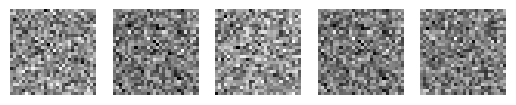

2D latent representations of the training data produced by encoder after 0 epoch(s): 


ValueError: too many values to unpack (expected 2)

In [82]:
#loss
mse_losses = []
kl_losses = []
# optimizer 
optimizer =  tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )
epochs = 5

for epoch in range(epochs):
    
    print(f"Samples generated by decoder after {epoch} epoch(s): ")
    
    #random noise
    z = tf.random.normal(shape = (5, latent_dim,))

    # input random noise into the decoder
    xhat = decoder.predict(z)
    
    # plot the decoder output
    plt.figure()
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(xhat[i,:,:,0],cmap="gray")
        plt.axis("off")
    plt.show()

    print(f"2D latent representations of the training data produced by encoder after {epoch} epoch(s): ")
    plot_label_clusters(encoder, X_train, y_train)


    # training steps
    for (step, training_batch) in enumerate(dataset.batch(100)):
        with tf.GradientTape() as tape:

            # model output
            reconstructed = model(training_batch)

            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])

            # calculate reconstruction loss
            mse_loss = reconstruction_loss(y_true, y_pred)
            # calculate KL divergence
            kl = sum(model.losses)

            kl_losses.append(kl.numpy())
            mse_losses.append(mse_loss .numpy())

            # total loss
            train_loss = 0.01 * kl + mse_loss

            grads = tape.gradient(train_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
         
    print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))
  

We plot the reconstruction loss and Kullback–Leibler divergence against the number of training iterations, we can see that they are both decreasing.


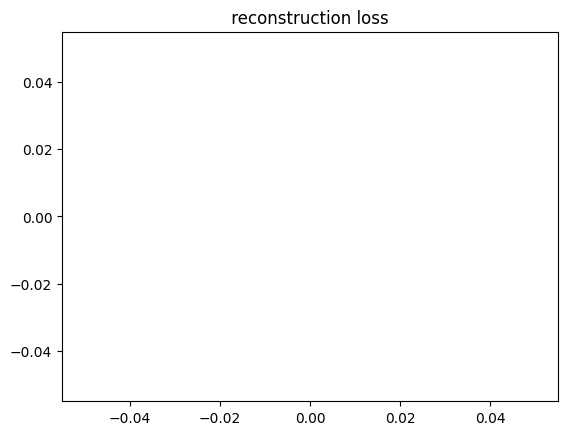

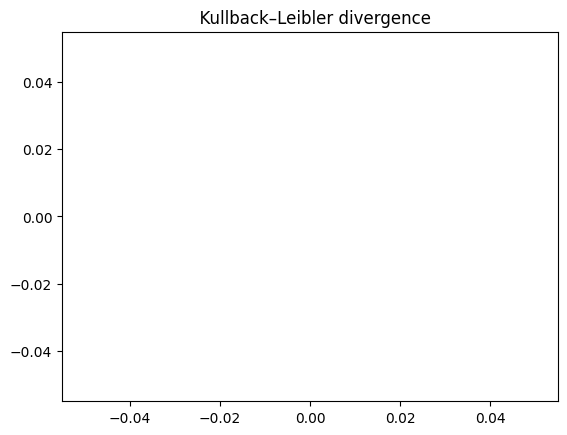

In [93]:
plt.plot(mse_losses)
plt.title(" reconstruction loss ")
plt.show()
plt.plot(kl_losses)
plt.title("  Kullback–Leibler divergence")
plt.show()

Now that our VAE has been trained, we can use its decoder network to generate some samples. Let's see if our decoder can do a good job in generating artificial images that look like digits!


In [94]:
xhat = decoder.predict(z)

for i in range(5):
    plt.imshow(xhat[i,:,:,0],cmap="gray")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

We can also visualize the final latent representations of the training data produced by the trained encoder on a 2D plot, colored by classes.


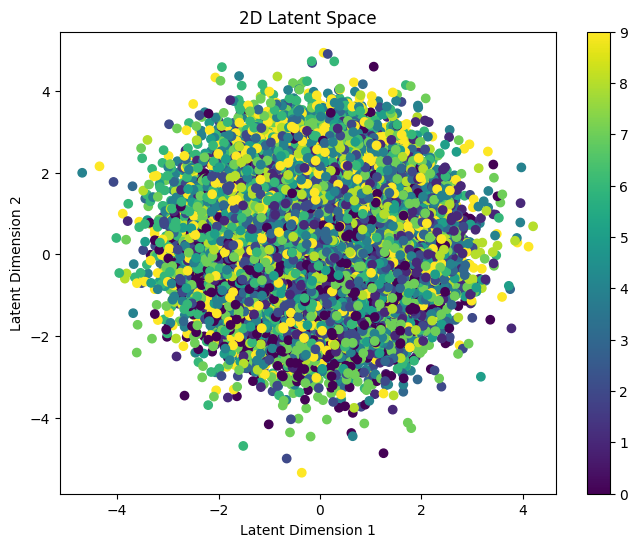

In [95]:
plot_label_clusters(encoder, X_train, y_train)

## Congratulations! You have completed this lab.


## Authors


[Joseph Santarcangelo](https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera35714171-2022-01-01) is a Data Science intern at IBM Skills Network, entering level-5 study in the Mathematics & Statistics undergraduate Coop program at McMaster University.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description      |
| ----------------- | ------- | ---------- | ----------------------- |
| 2022-09-14        | 0.1     | Joseph S.  | Created Lab             |
| 2022-09-19        | 0.1     | Roxanne Li | Reviewed and edited lab |


Copyright © 2022 IBM Corporation. All rights reserved.
